In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms

import medmnist
from medmnist import INFO, Evaluator

In [2]:
DATASET = 'bloodmnist'
BATCH_SIZE = 128
LATENT_DIM = 128
EPOCHS = 30
LR = 3e-3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
info = INFO[DATASET]
DataClass = getattr(medmnist, info['python_class'])

transform = transforms.ToTensor()
train_dataset = DataClass(split='train', transform=transform, download=True)
test_dataset = DataClass(split='test', transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super(VAE, self).__init__()

        self.enc_conv = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.fc_mu = nn.Linear(64*7*7, latent_dim)
        self.fc_logvar = nn.Linear(64*7*7, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 64*7*7)
        
        self.dec_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        h = self.enc_conv(x)
        h = h.view(h.size(0), -1)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        return mu, logvar
        
    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(-1, 64, 7, 7)
        return self.dec_conv(h)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.rand_like(std)
        return mu + std * eps
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar
        

In [5]:
def vae_loss(x, x_recon, mu, logvar, use_bce=True):
    batch_size = x.size(0)

    if use_bce:
        recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum') / batch_size
    else: 
        recon_loss = F.mse_loss(x_recon, x, reduction='sum') / batch_size

    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size
    
    return recon_loss + kld, recon_loss, kld

In [9]:
model = VAE().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)
KL_WARMUP = 30

for epoch in range(EPOCHS):
    model.train()
    total_loss, l2_loss, kl_loss = 0, 0, 0
    beta = min(1.0, (epoch + 1) / KL_WARMUP)
    for x, _ in tqdm(train_loader):
        x = x.to(DEVICE)
        x_recon, mu, sigma = model(x)
        loss, l2, kl = vae_loss(x, x_recon, mu, sigma)
        loss = l2 + kl * beta

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        l2_loss += l2.item()
        kl_loss += kl.item()

    print(f"Epoch {epoch+1}: loss={total_loss/len(train_loader):.4f}, "
          f"recon={l2_loss/len(train_loader):.4f}, kl={kl_loss/len(train_loader):.4f}")

100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.25it/s]


Epoch 1: loss=1245.2586, recon=1238.7564, kl=195.0662


100%|███████████████████████████████████████████| 94/94 [00:18<00:00,  5.13it/s]


Epoch 2: loss=1185.8300, recon=1181.3599, kl=67.0513


100%|███████████████████████████████████████████| 94/94 [00:09<00:00,  9.61it/s]


Epoch 3: loss=1175.7414, recon=1171.5691, kl=41.7236


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.02it/s]


Epoch 4: loss=1170.6212, recon=1165.8302, kl=35.9325


100%|███████████████████████████████████████████| 94/94 [00:11<00:00,  8.30it/s]


Epoch 5: loss=1168.0115, recon=1162.5520, kl=32.7576


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 10.75it/s]


Epoch 6: loss=1166.4036, recon=1160.4045, kl=29.9951


100%|███████████████████████████████████████████| 94/94 [00:09<00:00,  9.96it/s]


Epoch 7: loss=1166.0292, recon=1159.4368, kl=28.2530


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.22it/s]


Epoch 8: loss=1166.0403, recon=1158.9626, kl=26.5414


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.58it/s]


Epoch 9: loss=1165.9176, recon=1158.3958, kl=25.0728


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.26it/s]


Epoch 10: loss=1166.2244, recon=1158.2758, kl=23.8458


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.31it/s]


Epoch 11: loss=1166.3728, recon=1158.0588, kl=22.6746


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 10.53it/s]


Epoch 12: loss=1166.8823, recon=1158.2130, kl=21.6734


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.19it/s]


Epoch 13: loss=1167.0755, recon=1158.1263, kl=20.6522


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.46it/s]


Epoch 14: loss=1167.2481, recon=1157.9873, kl=19.8447


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 10.89it/s]


Epoch 15: loss=1167.7049, recon=1158.1683, kl=19.0732


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.03it/s]


Epoch 16: loss=1167.9999, recon=1158.2107, kl=18.3548


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.28it/s]


Epoch 17: loss=1168.2302, recon=1158.2000, kl=17.7003


100%|███████████████████████████████████████████| 94/94 [00:09<00:00, 10.41it/s]


Epoch 18: loss=1168.6786, recon=1158.4164, kl=17.1038


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.03it/s]


Epoch 19: loss=1169.0546, recon=1158.5451, kl=16.5940


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 10.95it/s]


Epoch 20: loss=1169.2791, recon=1158.6004, kl=16.0180


100%|███████████████████████████████████████████| 94/94 [00:09<00:00, 10.40it/s]


Epoch 21: loss=1169.7030, recon=1158.7787, kl=15.6061


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.23it/s]


Epoch 22: loss=1170.1221, recon=1159.0398, kl=15.1122


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 10.49it/s]


Epoch 23: loss=1170.5473, recon=1159.2064, kl=14.7925


100%|███████████████████████████████████████████| 94/94 [00:09<00:00, 10.20it/s]


Epoch 24: loss=1170.8278, recon=1159.3605, kl=14.3341


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.18it/s]


Epoch 25: loss=1171.3040, recon=1159.6056, kl=14.0380


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 10.90it/s]


Epoch 26: loss=1171.5046, recon=1159.6852, kl=13.6378


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 11.54it/s]


Epoch 27: loss=1171.9572, recon=1159.9771, kl=13.3112


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 10.50it/s]


Epoch 28: loss=1172.3969, recon=1160.2201, kl=13.0466


100%|███████████████████████████████████████████| 94/94 [00:08<00:00, 10.88it/s]


Epoch 29: loss=1172.6910, recon=1160.3533, kl=12.7631


100%|███████████████████████████████████████████| 94/94 [00:11<00:00,  8.52it/s]

Epoch 30: loss=1172.8902, recon=1160.4533, kl=12.4369


In [10]:
model.eval()
test_batch, _ = next(iter(test_loader))
test_batch = test_batch.to(DEVICE)
with torch.no_grad():
    recon, _, _ = model(test_batch)

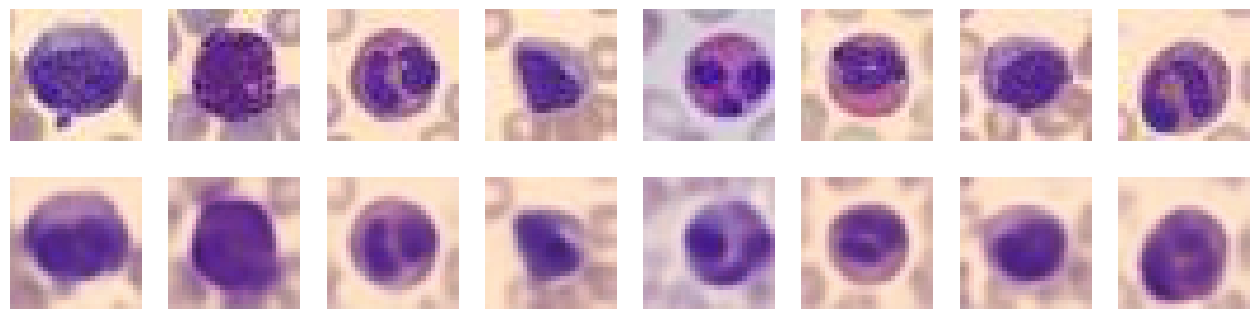

In [11]:
import matplotlib.pyplot as plt

n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test_batch[i].permute(1,2,0).cpu())
    plt.axis("off")
    # Reconstructed
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(recon[i].permute(1,2,0).cpu())
    plt.axis("off")
plt.show()